# Imports

In [1]:
from channels.ina_testing import (dias2014_iv,
                                  nakajima_inactivation,
                                  zhang_recovery)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
from ionchannelABC.experiment import setup

In [3]:
modelfile = 'models/ina_markov.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                dias2014_iv,
                                                nakajima_inactivation,
                                                zhang_recovery)

In [6]:
test = model(prior.rvs())

In [8]:
ss = summary_statistics(test)

In [11]:
assert(len(ss)==len(observations))

## Set limits and generate uniform initial priors

In [5]:
from pyabc import Distribution, RV
limits = {'ina.g_Na': (0., 100.),
          'ina.E_Na_offset': (-100, 100),
          'log_ina.p_1': (-7., 3.),
          'ina.p_2': (1e-7, 0.4),
          'log_ina.p_3': (-7., 3.),
          'ina.p_4': (1e-7, 0.4),
          'log_ina.p_5': (-7., 3.),
          'ina.p_6': (1e-7, 0.4),
          'log_ina.p_7': (-7., 3.),
          'ina.p_8': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [8]:
test = log_model(prior.rvs())

## Run ABC calibration

In [9]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_ina_markov.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ina_markov.db


In [10]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [11]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [12]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=log_model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.2665485024022797, '1': 0.462044670017176, '2': 0.43302153596354354, '3': 0.461980228640604, '4': 0.49505279320776174, '5': 0.08662242548550923, '6': 0.10499550650922806, '7': 0.12157151338165031, '8': 0.17768470332330974, '9': 0.22353882030996863, '10': 0.2771649434652451, '11': 0.3464670508187988, '12': 0.3849611528099394, '13': 0.2099777013853015, '14': 0.18237065679420406, '15': 1.244482816343679, '16': 1.0785517741645285, '17': 1.1555911866048552, '18': 0.8987931451371055, '19': 0.9516633301451682, '20': 0.7353762096576325, '21': 0.539275887082263, '22': 0.9516633301451682, '23': 1.0111422882792485, '24': 1.7975862902742272, '25': 0.951663330145177, '26': 2.1611342452784923, '27': 2.1611342452784923, '28': 2.1611342452784923, '29': 2.1611342452784923, '30': 2.1611342452784923, '31': 2.1611342452784923, '32': 2.1611342452784923, '33': 2.1611342452784923, '34': 2.1611342452784923}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile

In [13]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [14]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-07-06 09:08:39.684892, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.0, max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 12256
DEBUG:Epsilon:new eps, t=1, eps=7.659879918423631
INFO:ABC:t:1 eps:7.659879918423631
DEBUG:ABC:now submitting population 1


In [ ]:
history = abc.run(minimum_epsilon=0.0, max_nr_populations=100, min_acceptance_rate=0.005)

## Results analysis

In [17]:
from pyabc import History
history = History('sqlite:////scratch/cph211/tmp/hl-1_ina_markov.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2019-07-06 09:08:39.684892, end_time=2019-07-09 19:31:06.897879)>]

In [18]:
history.id = 1
df, w = history.get_distribution(m=0)

In [19]:
df.describe()

name,ina.E_Na_offset,ina.g_Na,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,46.133635,14.001827,0.111611,1.070535e-05,0.104608,0.056675,1.119136,-1.408975,0.888114,-4.350350
std,0.028203,0.030201,0.000028,8.186144e-06,0.000046,0.000029,0.000427,0.000483,0.000622,0.001756
min,46.039495,13.904051,0.111394,1.002936e-07,0.104473,0.056588,1.116362,-1.411452,0.886260,-4.356380
25%,46.114032,13.980192,0.111595,4.481741e-06,0.104576,0.056654,1.118869,-1.409252,0.887671,-4.351590
50%,46.133808,14.000895,0.111617,8.824305e-06,0.104607,0.056674,1.119173,-1.408912,0.888104,-4.350291
75%,46.153618,14.022876,0.111632,1.499237e-05,0.104640,0.056695,1.119447,-1.408638,0.888546,-4.349068
max,46.221473,14.101738,0.111663,5.532847e-05,0.104760,0.056770,1.120153,-1.407778,0.890133,-4.345376


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


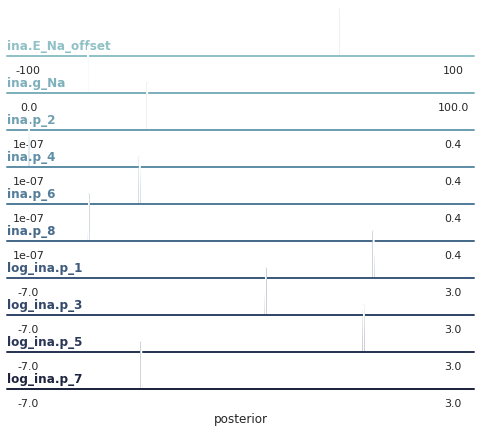

In [20]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [21]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [22]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(log_model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

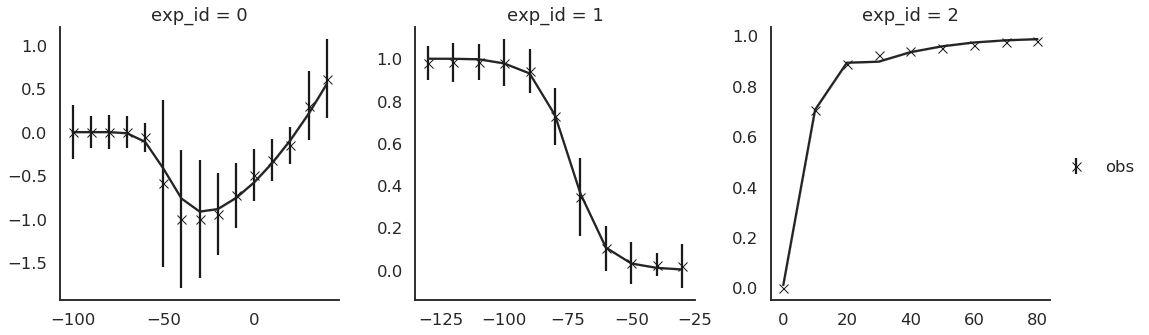

In [23]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

In [113]:
# Require discrete samples for exact measurements at -20mV
discrete_samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    discrete_samples = discrete_samples.append(output, ignore_index=True)

In [114]:
# Amplitude at -20 mV
grouped = discrete_samples[discrete_samples['exp']==0].groupby('sample')
def get_amplitude(group):
    return group.loc[group.x==-20]['y']
print(grouped.apply(get_amplitude).mean())
print(grouped.apply(get_amplitude).std())

-163.74165119888335
0.14129370301730562


In [115]:
import scipy.stats as st
peak_current = discrete_samples[discrete_samples['exp']==0].groupby('sample').apply(get_amplitude).tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -163.81705987307208
95% CI: (-163.85178097293564, -163.4658692841079)


In [116]:
# Voltage and slope factor at half-activation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [117]:
print(output.mean())
print(output.std())

0   -34.955683
1     7.200565
dtype: float64
0    0.015053
1    0.010894
dtype: float64


In [118]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.96014346870338
95% CI: (-34.97005619255574, -34.926599614270145)


In [119]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.197369620500938
95% CI: (7.19090481887031, 7.224585984649747)


In [120]:
# Voltage and slope factor at half-inactivation
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (-50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [121]:
print(output.mean())
print(output.std())

0   -72.193234
1     6.109548
dtype: float64
0    0.125658
1    0.078064
dtype: float64


In [122]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -72.21669685772069
95% CI: (-72.44020974010718, -71.87864783039117)


In [123]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 6.154343522380662
95% CI: (5.931996934878577, 6.207057392589782)
